In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Variational Inference Examples

We introduce variational inference (VI) for approximate Bayesian Inference.
We implement VI from scratch in `pytorch` and we also show how to do it in `pyro`.


+ [Variational Inference: A Review for Statisticians (Blei et al, 2018)](https://arxiv.org/pdf/1601.00670.pdf).
+ [Automatic Differentiation Variational Inference (Kucukelbir et al, 2016)]( https://arxiv.org/pdf/1603.00788.pdf).
+ [Autoencoding Variational Bayes (Kingma and Welling, 2014)](https://arxiv.org/pdf/1312.6114.pdf).
+ [Black Box Variational Inference (Ranganath et al, 2013)](https://arxiv.org/pdf/1401.0118.pdf).
+ [Stein Variational Gradient Descent (Liu and Wang, 2016)](https://arxiv.org/pdf/1608.04471.pdf).
+ [Variational Inference with Normalizing Flows (Rezende and Mohamed, 2016)](https://arxiv.org/pdf/1505.05770.pdf).

**Note:** This notebook was originally developed by [Dr. Rohit Tripathy](https://rohittripathy.netlify.com) in `PyMC`. It was modified by [Prof. Bilionis](www.predictivesciencelab.org) using `pytorch` and `pyro`.

In [ ]:
# Do this in Google Colab
!pip install pyro-ppl

## Example 1 - normal-normal model

Let's demonstrate the VI process end-to-end with a simple example.
Consider the task of inferring the gravitational constant from data. 
We perform experiments $x_{1:n}$ which measure the acceleration of gravity, and we know that the measurement standard deviation is $\sigma = 0.1$.
Here are some synthetic data.

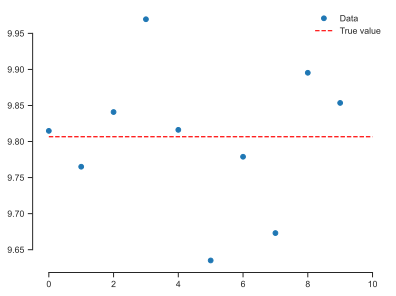

In [2]:
import torch
import scipy.constants
g_true = scipy.constants.g

# Generate some synthetic data
n = 10
sigma = 0.1
data = g_true + sigma * torch.randn(n)

plt.plot(np.arange(n), data, 'o', label='Data')
plt.plot(np.linspace(0, n, 100), g_true*np.ones(100), '--', color="r", label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)

The likelihood of each measurement is given by:

$$
x_i | g, \sigma \sim N(g, \sigma^2).
$$

So, the model says that the measured acceleration of gravity is around the true one with some Gaussian noise.
Assume that our prior state-of-knowledge over $g$ is:

$$
g | g_0, s_0 \sim N(g_0, s_0^2),
$$

with known $g_0 = 10$, $s_0 = 0.4$.
This is a, so-called, [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) and the posterior over $g$ is given analytically by:

$$
g|x_{1:n} \sim N(\tilde{g}, \tilde{s}^2),
$$

where

$$
\tilde{s}^2 = \left( \frac{n}{\sigma^2} + \frac{1}{s_0^2} \right)^{-1},
$$

and

$$
\tilde{g} = \tilde{s}^2 \left( \frac{g_0}{s_0^2} + \frac{\sum_{i=1}^{n} x_i}{\sigma^2}\right).
$$

Let's write some code to get this analytical posterior:

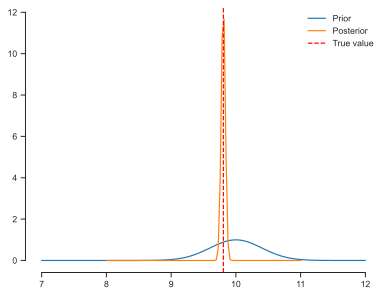

In [3]:
def post_mean_and_variance(prior_mean, prior_variance, data, likelihood_var):
    n = len(data)
    sigma2 = likelihood_var
    s02 = prior_variance
    m0 = prior_mean
    sumdata = torch.sum(data)
    post_prec = (n/sigma2) + (1./s02)
    post_var = 1./post_prec
    post_mean = post_var * ((m0/s02) + (sumdata/sigma2))
    return post_mean, post_var

gtilde, s2tilde = post_mean_and_variance(10., 0.4**2, data, 0.1**2)

xs1 = torch.linspace(7, 12, 100)
xs2 = torch.linspace(8, 11, 100)
plt.plot(xs1, st.norm(loc=10., scale=0.4).pdf(xs1), label='Prior')
plt.plot(xs2, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs2), label='Posterior')
plt.axvline(g_true, color='r', linestyle='--', label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Now let's try to infer the posterior over $g$ using VI. We specify the joint log probability of the model first.
We do everything using `pytorch` so that we can use automatic differentiation.

In [4]:
g0 = torch.tensor(10.)
s0 = torch.tensor(0.4)
sigma = torch.tensor(0.1)

def logprior(g):
    return torch.distributions.Normal(g0, s0).log_prob(g)

def loglikelihood(data, g):
    return torch.distributions.Normal(g, sigma).log_prob(data).sum()

def logjoint(data, g):
    return logprior(g) + loglikelihood(data, g)

We must specify a parameterized approximate posterior, $q_{\phi}(\cdot)$. The obvious choice here is a Gaussian:

$$
q_{\phi}(g) = N(g | \phi_1, \exp(\phi_2)^2),
$$

where, $\phi = (\phi_1, \phi_2)$ are the variational parameters. The ELBO needs to be maximized with respect to $\phi$. Let's go ahead and set up the ELBO. Recall that the ELBO is given by:

$$
\text{ELBO}(\phi) =  \mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})] + \mathbb{H}[q(\theta)].
$$

The entropy is given by:

$$
\mathbb{H}[q(\theta)] = 1/2\log(2\pi \exp(\phi_2)^2) + 1/2 = \phi_2 + \text{const}.
$$

To optimize the ELBO, we must compute an expectation over the variational distribution $q$ (first term on the RHS in the above equation). This cannot be done analytically. Instead, we resort to a Monte Carlo approximation:

$$
\mathbb{E}_q [\log p(\theta, \mathbf{x})] \approx \frac{1}{S}\sum_{s=1}^{S}   \log p(\theta^{(s)}, \mathbf{x}),
$$

where the samples $\theta^{(s)}$ are drawn from $q$.

Here is the code for the ELBO:

In [5]:
def ELBO(phi, data, num_samples):
    g_samples = phi[0] + torch.exp(phi[1]) * torch.randn(num_samples)
    return logjoint(data, g_samples).mean() + phi[1]


def negELBO(phi, data, num_samples):
    return -ELBO(phi, data, num_samples)

Now we can setup the optimization problem.
Here we go:

In [6]:
from torch import optim

num_samples = 10
num_iter = 20_000
phi = torch.tensor([9.0, -1.0])
phi.requires_grad_(True)
optimizer = optim.Adam([phi], lr=0.001)

elbos = []
for i in range(num_iter):
    optimizer.zero_grad()
    loss = negELBO(phi, data, num_samples)
    loss.backward()
    optimizer.step()
    if i % 1_000 == 0:
        print(f"Iteration: {i} Loss: {loss.item()}")
    elbos.append(-loss.item())
phi.requires_grad_(False);

Iteration: 0 Loss: 375.7824401855469
Iteration: 1000 Loss: 26.652555465698242
Iteration: 2000 Loss: 2.5472326278686523
Iteration: 3000 Loss: -1.334648847579956
Iteration: 4000 Loss: 0.9369990825653076
Iteration: 5000 Loss: -7.821878433227539
Iteration: 6000 Loss: -0.5406231880187988
Iteration: 7000 Loss: -6.518988609313965
Iteration: 8000 Loss: -5.652396202087402
Iteration: 9000 Loss: -5.485063076019287
Iteration: 10000 Loss: -5.161447525024414
Iteration: 11000 Loss: -7.376476287841797
Iteration: 12000 Loss: -5.037634372711182
Iteration: 13000 Loss: -3.8640382289886475
Iteration: 14000 Loss: -3.771669626235962
Iteration: 15000 Loss: -4.731598854064941
Iteration: 16000 Loss: -5.233105182647705
Iteration: 17000 Loss: -5.517479419708252
Iteration: 18000 Loss: -5.228094100952148
Iteration: 19000 Loss: -6.046360015869141


Here is the evolution of the ELBO:

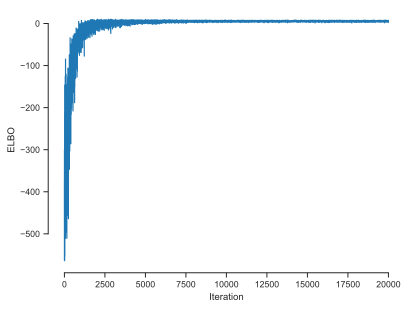

In [7]:
fig, ax = plt.subplots()
ax.plot(torch.arange(num_iter), elbos)
ax.set(xlabel='Iteration', ylabel='ELBO')
sns.despine(trim=True);

Let's build and visualize the approximate posterior:

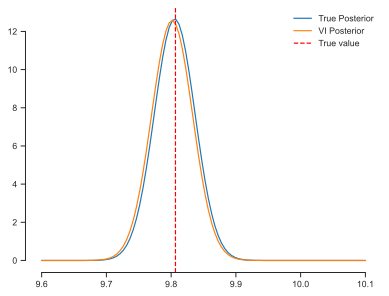

In [8]:
postmean = phi[0]
poststdev = torch.exp(phi[1])
gpost = st.norm(postmean, poststdev)

xs = np.linspace(9.6, 10.1, 100)
fig, ax = plt.subplots()
ax.plot(xs, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs), label='True Posterior')
ax.plot(xs, gpost.pdf(xs), label='VI Posterior')
ax.axvline(g_true, color='r', linestyle='--', label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

As you can see, our approximation of the posterior is close. The normal-normal model is a straightforward example with one latent variable. In practice, setting up the variational posterior for all latent variables, keeping track of transformations, and optimizing the variational parameters can become tedious for models of any reasonable level of complexity. 

Now let's do the same thing using `pyro`:

In [9]:
import pyro
import pyro.distributions as dist


def model(data):
    g = pyro.sample("g", pyro.distributions.Normal(g0, s0))
    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", pyro.distributions.Normal(g, sigma), obs=data)

We need to define the guide. We can either do it by hand or use the `AutoNormal` guide.
The `AutoNormal` scans the model for laten variables (in our model the only such variable is `g`) and it constructs a guide that is a normal distribution with learnable parameters.

In [10]:
guide = pyro.infer.autoguide.AutoNormal(model)

Then we can do inference:

In [11]:
# This removes old parameters from the parameter store.
# If you don't do this, you'll overwrite parameters from
# previous runs.
pyro.clear_param_store()

# This is the stochastic variational inference algorithm:
svi = pyro.infer.SVI(
    model,              # model to optimize
    guide,              # variational distribution
    pyro.optim.Adam(    # optimizer to use
        {"lr": 0.001}   # parameters of the optimizer
    ),
    pyro.infer.JitTrace_ELBO() # loss optimization function - here, the ELBO
)

# And we can iterate:
num_iter = 20_000
elbos = []
for i in range(num_iter):
    loss = svi.step(data)
    elbos.append(-loss)
    if i % 1_000 == 0:
        print(f"Iteration: {i} Loss: {loss}")

Iteration: 0 Loss: 49686.4765625
Iteration: 1000 Loss: 40596.5390625
Iteration: 2000 Loss: 30614.01953125
Iteration: 3000 Loss: 24874.3671875
Iteration: 4000 Loss: 19644.50390625
Iteration: 5000 Loss: 12995.2060546875
Iteration: 6000 Loss: 9540.4306640625
Iteration: 7000 Loss: 6226.10107421875
Iteration: 8000 Loss: 3715.46435546875
Iteration: 9000 Loss: 2070.754150390625
Iteration: 10000 Loss: 1292.1932373046875
Iteration: 11000 Loss: 252.4281463623047
Iteration: 12000 Loss: 38.22501754760742
Iteration: 13000 Loss: -5.493821620941162
Iteration: 14000 Loss: -2.04667329788208
Iteration: 15000 Loss: -7.136266708374023
Iteration: 16000 Loss: -5.793765544891357
Iteration: 17000 Loss: -7.158337116241455
Iteration: 18000 Loss: -7.028347015380859
Iteration: 19000 Loss: -6.882040023803711


Let's put the training loop in a function for later use:

In [12]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.
    
    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 100 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

Let's plot the ELBO:

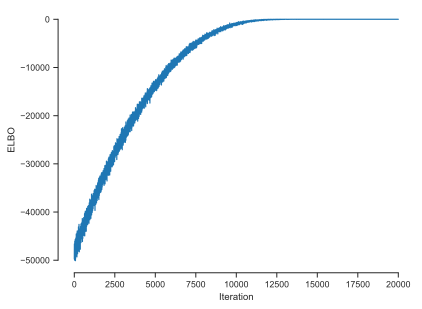

In [13]:
fig, ax = plt.subplots()
ax.plot(torch.arange(num_iter), elbos)
ax.set(xlabel='Iteration', ylabel='ELBO')
sns.despine(trim=True);

Here is how you can extract information from the posterior:

In [14]:
guide.median() # Only works for AutoGuide

{'g': tensor(9.7988)}

In [15]:
guide.quantiles([0.25, 0.75]) # Only works for AutoGuide

{'g': tensor([9.7757, 9.8218])}

The other thing that you can do is use `pyro.infer.Predictive` to get samples from the guide:

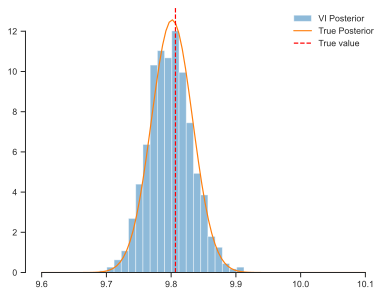

In [16]:
guide_g_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)(data)["g"]
fig, ax = plt.subplots()
# You have to detach the tensor from the computational graph
# otherwise it doesn't work.
ax.hist(guide_g_samples.detach().numpy(), bins=20, density=True, label='VI Posterior', alpha=0.5)
ax.plot(xs, gpost.pdf(xs), label='True Posterior')
ax.axvline(g_true, color='r', linestyle='--', label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

The above code works with every guide, even hand-written ones.

Let's repeat the above example using our own guide.
The results will be identical because `AutoNormal` is just a normal distribution with learnable parameters.

In [17]:
def guide(data):
    mu = pyro.param("mu", torch.tensor(9.0))
    sigma = pyro.param("sigma", torch.tensor(2.0),
                       constraint=dist.constraints.positive)
    pyro.sample("g", pyro.distributions.Normal(mu, sigma))

That's it. Now, whenever `pyro` sees a `pyro.param` it understands that it needs to optimize it.
Let's test i:

In [18]:
elbos, params = train(model, guide, (data,), num_iter=20_000);

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_58779/2942119673.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mu = pyro.param("mu", torch.tensor(9.0))
/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_58779/2942119673.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma = pyro.param("sigma", torch.tensor(2.0),


Iteration: 0 Loss: 6863.5166015625
Iteration: 100 Loss: 4726.62841796875
Iteration: 200 Loss: 6681.0615234375
Iteration: 300 Loss: 1037.7930908203125
Iteration: 400 Loss: 5512.32958984375
Iteration: 500 Loss: 1687.9530029296875
Iteration: 600 Loss: 5955.34765625
Iteration: 700 Loss: 318.48486328125
Iteration: 800 Loss: -0.43179094791412354
Iteration: 900 Loss: 1379.1673583984375
Iteration: 1000 Loss: 1462.825927734375
Iteration: 1100 Loss: 62.86969757080078
Iteration: 1200 Loss: 1187.942138671875
Iteration: 1300 Loss: -10.333321571350098
Iteration: 1400 Loss: 1810.6552734375
Iteration: 1500 Loss: 17.4462890625
Iteration: 1600 Loss: 1257.30078125
Iteration: 1700 Loss: 7.44822883605957
Iteration: 1800 Loss: 1563.3077392578125
Iteration: 1900 Loss: 198.15220642089844
Iteration: 2000 Loss: 833.2096557617188
Iteration: 2100 Loss: 280.9329833984375
Iteration: 2200 Loss: -1.0198445320129395
Iteration: 2300 Loss: 342.187744140625
Iteration: 2400 Loss: 11.269716262817383
Iteration: 2500 Loss: -

The result, is essentially the same as before.

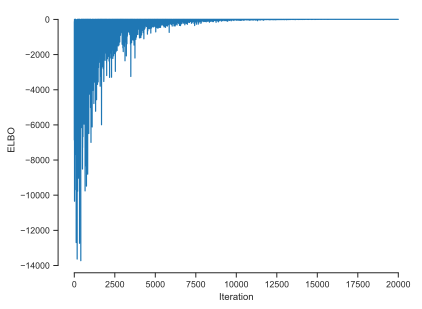

In [19]:
fig, ax = plt.subplots()
ax.plot(torch.arange(num_iter), elbos)
ax.set(xlabel='Iteration', ylabel='ELBO')
sns.despine(trim=True);

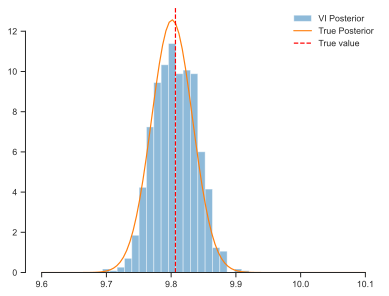

In [20]:
guide_g_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)(data)["g"]
fig, ax = plt.subplots()
# You have to detach the tensor from the computational graph
# otherwise it doesn't work.
ax.hist(guide_g_samples.detach().numpy(), bins=20, density=True, label='VI Posterior', alpha=0.5)
ax.plot(xs, gpost.pdf(xs), label='True Posterior')
ax.axvline(g_true, color='r', linestyle='--', label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Example 2 - Coin-toss example 

Just like in the MCMC lecture, let's look at the process of setting up a model and performing variational inference and diagnostics with the coin toss example.  

The probabilistic model is as follows. We observe binary coin toss data:

$$
x_i|\theta \sim \text{Bernoulli}(\theta),
$$

for $i=1, \dots, n$.

The prior over the latent variable $\theta$ is a Beta distribution:

$$
\theta \sim \text{Beta}(2, 2).
$$

We assign the prior as a Beta distribution with shape parameters 2 and 2, corresponding to a weak apriori belief that the coin is most likely fair.

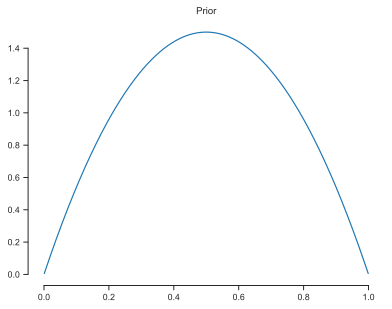

In [21]:
thetaprior = st.beta(2., 2.)
x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, thetaprior.pdf(x))
plt.title('Prior')
sns.despine(trim=True);

We wish to perform posterior inference on $\theta$:

$$
p(\theta| x_{1:n}) \propto p(\theta) \prod_{i=1}^{n} p(x_i | \theta).
$$

Since this is a conjugate model, we know the posterior in closed form:

$$
\theta | x_{1:n} \sim \text{Beta}\left(2+ \sum_{i=1}^n x_i, 2 + n - \sum_{i=1}^nx_i\right)
$$

Let's generate some fake data and get the analytical posterior for comparison.

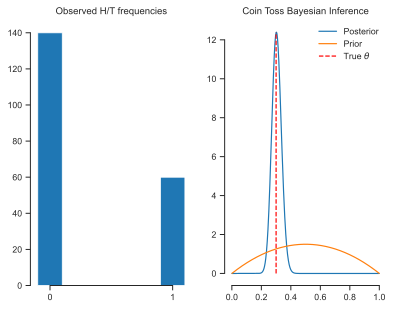

In [22]:
thetatrue =0.3
n = 200
data = torch.tensor(np.random.binomial(1, thetatrue, size=(n,)), dtype=torch.float32)
nheads = data.sum()
ntails = n - nheads
theta_post = st.beta(2. + nheads, 2. + ntails)

# plot data 
plt.figure()
plt.subplot(121)
_=plt.bar(*np.unique(data, return_counts=True), width=0.2)
_=plt.xticks([0, 1])
_=plt.title('Observed H/T frequencies')

# plot posterior
plt.subplot(122)
x = np.linspace(0.001, 0.999, 1000)
postpdf = theta_post.pdf(x)
y = np.linspace(0., np.max(postpdf), 100)
plt.plot(x, postpdf, label='Posterior')
plt.plot(x, thetaprior.pdf(x), label='Prior')
plt.plot(thetatrue*np.ones_like(y), y, color="r", linestyle='--', label='True $\\theta$')
plt.legend(loc='best', frameon=False)
plt.xticks()
plt.title('Coin Toss Bayesian Inference')
sns.despine(trim=True);

Let's make the model in `pyro`:

In [23]:
def model(data):
    theta = pyro.sample("theta", dist.Beta(1., 1.))
    with pyro.plate('data', data.shape[0]):
        pyro.sample('obs', dist.Bernoulli(theta), obs=data)

Now we need to make the guide.
We have many choices.
Let's try a couple.
First, let's just use a Gaussian.
We cannot use a Gaussian directly on $\theta$ though because its support is $[0, 1]$.
Instead, we put a Gaussian on a variable $z$ with support $\mathbb{R}$:

$$
z \sim N(\mu, \sigma^2).
$$

Then we transform $z$ to $\theta$ using the sigmoid function:

$$
\theta = \frac{1}{1 + \exp(-z)}.
$$

Here is how we can do this in `pyro`.
We can either do it by hand:

In [24]:
from pyro.distributions import constraints
from pyro.distributions import transforms

def gaussian_guide(data):
    mu = pyro.param('mu', torch.tensor(0.0))
    sigma = pyro.param('sigma', torch.tensor(.1), constraint=constraints.positive)
    pyro.sample(
        "theta",
        dist.TransformedDistribution(
            dist.Normal(mu, sigma),
            transforms.SigmoidTransform()
        )
    )

Or we can use the `AutoNormal` guide:

In [25]:
auto_gaussian_guide = pyro.infer.autoguide.AutoNormal(model)

These are identical. Let's just train the second one:

In [26]:
elbos, params = train(model, auto_gaussian_guide, (data,), num_iter=20_000);

Iteration: 0 Loss: 146.40711975097656
Iteration: 100 Loss: 141.49867248535156
Iteration: 200 Loss: 134.42784118652344
Iteration: 300 Loss: 129.84580993652344
Iteration: 400 Loss: 128.21202087402344
Iteration: 500 Loss: 130.95372009277344
Iteration: 600 Loss: 129.74700927734375
Iteration: 700 Loss: 128.5478515625
Iteration: 800 Loss: 122.86455535888672
Iteration: 900 Loss: 126.47606658935547
Iteration: 1000 Loss: 124.5881118774414
Iteration: 1100 Loss: 124.98439025878906
Iteration: 1200 Loss: 125.36991119384766
Iteration: 1300 Loss: 125.0341567993164
Iteration: 1400 Loss: 123.77005004882812
Iteration: 1500 Loss: 124.68547058105469
Iteration: 1600 Loss: 124.85704040527344
Iteration: 1700 Loss: 124.83834838867188
Iteration: 1800 Loss: 124.78903198242188
Iteration: 1900 Loss: 124.77840423583984
Iteration: 2000 Loss: 124.79694366455078
Iteration: 2100 Loss: 124.2547378540039
Iteration: 2200 Loss: 124.69900512695312
Iteration: 2300 Loss: 124.7703857421875
Iteration: 2400 Loss: 124.5439147949

The evolution of the ELBO:

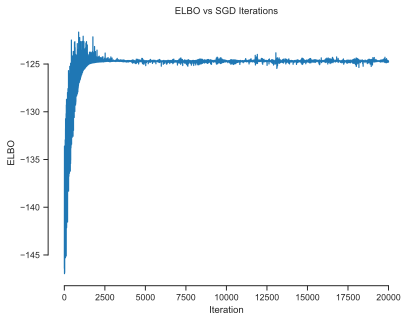

In [27]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel='Iteration', ylabel='ELBO', title='ELBO vs SGD Iterations')
sns.despine(trim=True);

Here is the posterior:

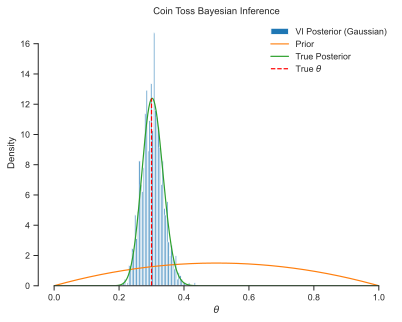

In [28]:
thetas = pyro.infer.Predictive(model, guide=auto_gaussian_guide, num_samples=1_000)(data)["theta"]

fig, ax = plt.subplots()
ax.hist(thetas.detach().numpy(), bins=50, density=True, label='VI Posterior (Gaussian)')
ax.plot(x, thetaprior.pdf(x), label='Prior')
ax.plot(x, theta_post.pdf(x), label='True Posterior')
ax.plot(thetatrue*np.ones_like(y), y, color="r", linestyle='--', label='True $\\theta$')
ax.legend(loc='best', frameon=False)
ax.set(xlabel='$\\theta$', ylabel='Density', title='Coin Toss Bayesian Inference')
sns.despine(trim=True);

Pretty good.

## Example 3 - Challenger Space Shuttle Disaster

Let's revisit this example from the MCMC lecture.

In [29]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

In [30]:
# load data 
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


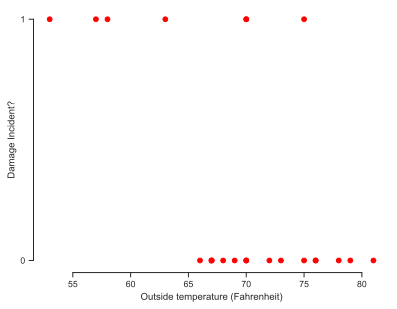

In [31]:
fig, ax = plt.subplots()
ax.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro')
ax.set(ylabel="Damage Incident?", xlabel="Outside temperature (Fahrenheit)")
plt.yticks([0, 1])
plt.xticks()
sns.despine(trim=True);

### Probabilistic model 

The defect probability is modeled as a function of the outside temperature:

$$
\sigma(t;\alpha,\beta) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } }.
$$

The goal is to infer the latent variables $\alpha$ and $\beta$. 

We set normal priors on the latent variables:

$$
\alpha \sim N(0, 10^2),
$$

and

$$
\beta \sim N(0, 10^2),
$$ 

and the likelihood model is given by:

$$
p(x_i | \alpha, \beta, t) = \text{Bernoulli}(x_i | \sigma(t; \alpha, \beta) ).
$$

Here is the model in `pyro`:

In [32]:
challenger_data = torch.tensor(challenger_data)
temperature = challenger_data[:, 0]
defect = challenger_data[:, 1]

def model(temperature, defect):
    alpha = pyro.sample('alpha', dist.Normal(0., 100.))
    beta = pyro.sample('beta', dist.Normal(0., 100.))
    with pyro.plate('data', temperature.shape[0]):
        logits = pyro.deterministic('logits', alpha + beta * temperature)
        pyro.sample('obs', dist.Bernoulli(logits=logits), obs=defect)
    return locals()

We will use the `AutoNormal` guide:

In [33]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

elbos, params = train(model, guide, (temperature, defect), num_iter=40_000);

Iteration: 0 Loss: 5531.840440750122
Iteration: 100 Loss: 5467.439811468124
Iteration: 200 Loss: 5410.4613201618195
Iteration: 300 Loss: 5439.929831027985
Iteration: 400 Loss: 5344.992549419403
Iteration: 500 Loss: 5336.480083465576
Iteration: 600 Loss: 5237.499451160431
Iteration: 700 Loss: 5137.388278126717
Iteration: 800 Loss: 5212.8310779333115
Iteration: 900 Loss: 5149.711973071098
Iteration: 1000 Loss: 5135.877537846565
Iteration: 1100 Loss: 5152.2343854904175
Iteration: 1200 Loss: 4916.988680720329
Iteration: 1300 Loss: 4904.5195878744125
Iteration: 1400 Loss: 4859.160486340523
Iteration: 1500 Loss: 4790.789856433868
Iteration: 1600 Loss: 4793.873239278793
Iteration: 1700 Loss: 4716.390684723854
Iteration: 1800 Loss: 4715.97630906105
Iteration: 1900 Loss: 4699.5179080963135
Iteration: 2000 Loss: 4561.090007901192
Iteration: 2100 Loss: 4613.398386597633
Iteration: 2200 Loss: 4485.692254781723
Iteration: 2300 Loss: 4550.878390073776
Iteration: 2400 Loss: 4473.403885304928
Iteratio

It is always a good idea to plot the ELBO:

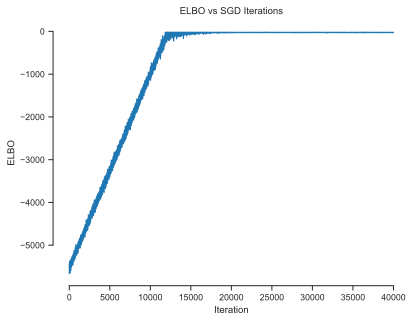

In [34]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel='Iteration', ylabel='ELBO', title='ELBO vs SGD Iterations')
sns.despine(trim=True);

Now let's plot the posterior of the parameters:

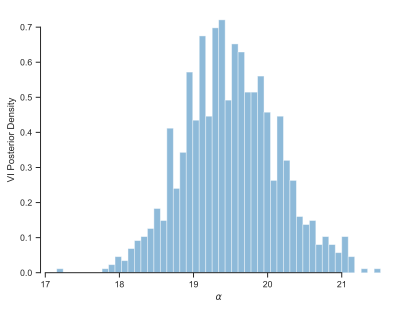

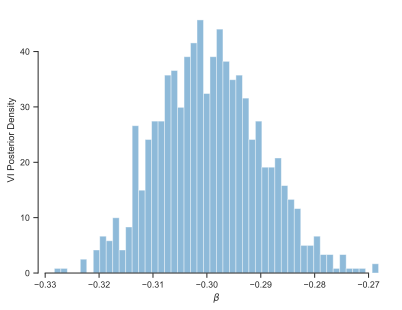

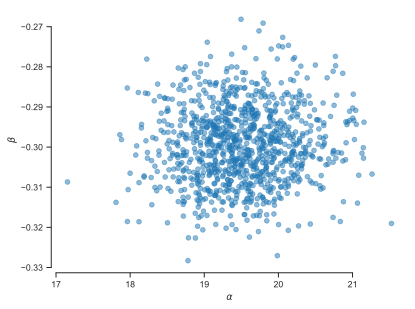

In [35]:
param_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)(temperature, defect)

alpha_samples = param_samples["alpha"]
beta_samples = param_samples["beta"]

fig, ax = plt.subplots()
ax.hist(alpha_samples.detach().numpy(), bins=50, density=True, label='VI Posterior ($\\alpha$)', alpha=0.5)
ax.set(xlabel='$\\alpha$', ylabel='VI Posterior Density')
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(beta_samples.detach().numpy(), bins=50, density=True, label='VI Posterior ($\\beta$)', alpha=0.5)
ax.set(xlabel='$\\beta$', ylabel='VI Posterior Density')
sns.despine(trim=True);

# Scatter plot of the samples
fig, ax = plt.subplots()
ax.scatter(alpha_samples.detach().numpy(), beta_samples.detach().numpy(), alpha=0.5)
ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
sns.despine(trim=True);

Now we would like to plot the posterior predictive distribution as a function of the temperature.

In [36]:
def predictive_model(temperature, defect):
    # Use the original model to define the variables
    vars = model(temperature, defect)
    alpha = vars["alpha"]
    beta = vars["beta"]
    temps = torch.linspace(temperature.min(), temperature.max(), 100)
    predictions = pyro.deterministic('predictions', torch.sigmoid(alpha + beta * temps))
    return locals()

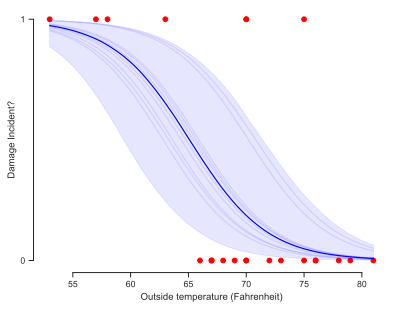

In [37]:
param_samples = pyro.infer.Predictive(
    predictive_model,
    guide=guide,
    num_samples=1_000
)(temperature, defect)

temps = torch.linspace(temperature.min(), temperature.max(), 100)
predictions = param_samples["predictions"]
pred_500, pred_025, pred_975 = predictions.quantile(torch.tensor([0.5, 0.025, 0.975]), dim=0)

fig, ax = plt.subplots()
ax.plot(temperature, defect, 'ro')
ax.plot(temps, pred_500.flatten(), 'b')
ax.fill_between(temps, pred_025.flatten(), pred_975.flatten(), color='b', alpha=0.1)
ax.set(ylabel="Damage Incident?", xlabel="Outside temperature (Fahrenheit)")
# Plot a few samples
for i in range(10):
    ax.plot(temps, predictions[i].flatten(), 'b', alpha=0.1)
plt.yticks([0, 1])
plt.xticks()
sns.despine(trim=True);